In [1]:
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt
import ODE_solver as ODE
import astropy.units as u
import astropy.constants as const

# Problem 2 - Solving the Damped Pendulum

Define the ODEs that will solve the equations of the damped pendulum. The following cells are taken directly from the odeint documentation found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

In [2]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

In [3]:
b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.arange(0, 10, 0.01)

In [4]:
from scipy.integrate import odeint
sol = odeint(pend, y0, t, args=(b,c))

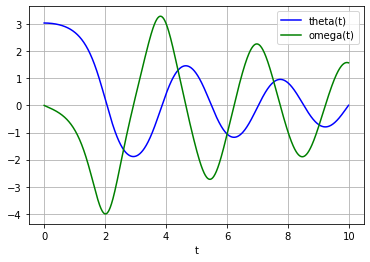

In [5]:
plt.plot(t, sol[:,0], 'b', label='theta(t)')
plt.plot(t, sol[:,1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

Now we will solve the same set of equations using my 3 ODE solvers and compare the results. 

In [6]:
## We have to define the function we want to solve, pend_ODE, as the output of another function that
## will pass the paramaters, b and c. This is due to the fact that my ODE solvers expect a function that takes input
## in the form (x, y) - in order to consider b and c, I would have to hardcode these inputs into my ODE solvers.
## But, we want the ODE solvers to be as general as possible. So hardcoding would be bad practice.
## Therefore, I can get around that by defining a function that sends the additional paramaters to the function
## we are solving for.
def pend_params(b, c):
    def pend_ODE(x, y):
        dydt = [y[1], -b*y[1] - c*np.sin(y[0])]
        return dydt
    return pend_ODE

## Define the points we want to the values of theta and omega at.
x = np.arange(0, 10, 0.01)

In [7]:
## Solve the equations using my 3 ODE solvers.
y_euler = ODE.euler_method(pend_params(0.25, 5.0), y0, x, 0.01)
y_heuns = ODE.heuns_method(pend_params(0.25, 5.0), y0, x, 0.01)
y_rk4 = ODE.rk4_method(pend_params(0.25, 5.0), y0, x, 0.01)

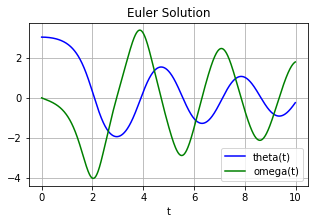

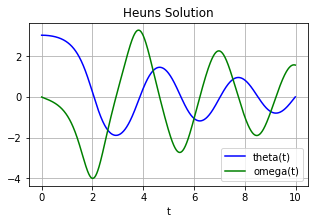

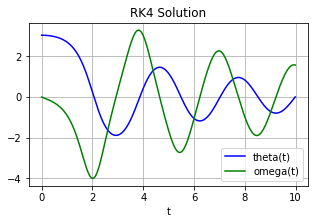

In [8]:
## Plot all of the results.


plt.figure(figsize=(5,3))
plt.title('Euler Solution')
plt.plot(x, y_euler[:,0], 'b', label='theta(t)')
plt.plot(x, y_euler[:,1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

plt.figure(figsize=(5,3))
plt.title('Heuns Solution')
plt.plot(x, y_heuns[:,0], 'b', label='theta(t)')
plt.plot(x, y_heuns[:,1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

plt.figure(figsize=(5,3))
plt.title('RK4 Solution')
plt.plot(x, y_rk4[:,0], 'b', label='theta(t)')
plt.plot(x, y_rk4[:,1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

We can also plot the absolute error between the two results to see how close to scipy.odeint our RK4 method gets. They differ by no more than $ \approx 5 \times 10^{-7} $.

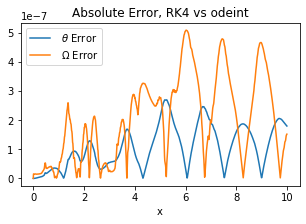

In [9]:
## Define absolute error as:
def abs_error(a, b):
    return np.abs(a - b)

## Calculate the absolute error.
error_theta = abs_error(y_rk4[:,0], sol[:,0])
error_omega = abs_error(y_rk4[:,1], sol[:,1])

## Plot the error
plt.figure(figsize=(5,3))
plt.title('Absolute Error, RK4 vs odeint')
plt.plot(x, error_theta, label = r" $\theta$ Error")
plt.plot(x, error_omega, label = r" $\Omega$ Error")
plt.xlabel('x')
plt.legend()
plt.show()

# Problem 3 - Stiff ODE Test

We will now solve this equation numerically:

$\frac{dy(t)}{dt} = -\lambda (y(t) - \cos(t))$ with $y(0) = 0$.

And compare it to the analytical solution of the form:

$y(t) = -\frac{\lambda^2}{1 + \lambda^2} e^{-\lambda t} + \frac{\lambda}{1 + \lambda^2} \sin(t) + \frac{\lambda^2}{1 + \lambda^2} \cos(t)$

In [10]:
x = np.arange(0, 5, 0.001)
y0 = 0.0
lam = 11

## Define the stiff ODE given in above.
def stiff_ODE_params(lam):
    def stiff_ODE(x, y):
        dydt = -lam * (y - np.cos(y))
        return dydt
    return stiff_ODE

## Define the exact solution.
def stiff_ODE_exact(lam, x):
    return lam/(1 + lam**2.0) * np.sin(x) + lam**2/(1 + lam**2) * np.cos(x) - lam**2/(1 + lam**2) * np.exp(-lam * x)

## Solve the equations using my 3 ODE solvers.
y_stiff_euler = ODE.euler_method(stiff_ODE_params(lam), y0, x, 0.001)
y_stiff_heuns = ODE.heuns_method(stiff_ODE_params(lam), y0, x, 0.001)
y_stiff_rk4 = ODE.rk4_method(stiff_ODE_params(lam), y0, x, 0.001)
y_stiff_exact = stiff_ODE_exact(lam, x)

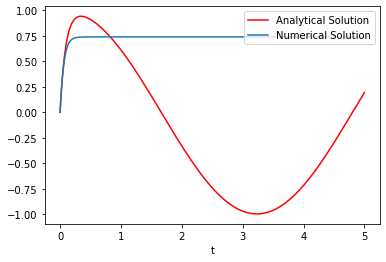

In [11]:
## Plot the solutions
plt.plot(x, y_stiff_exact, 'r', label='Analytical Solution')
plt.plot(x, y_stiff_euler, label='Numerical Solution')
plt.xlabel('t')
plt.legend(loc = 'upper right')
plt.show()


I am unable to solve this ODE with my numerical integrators. I've tried lowering the timestep from 0.01 down to 0.0000001 in increments of 0.1 with no promising results. According to many resources online, sometimes a very small timestep can be used to solve stiff ODEs with explicit methods. That doesn't seem to work for me. Nevertheless, I can only get through $\approx 250$ timesteps before the integrator fails. 

# Problem 4 - White Dwarf Mass vs Radius

In [44]:
## Define the pressure calculation found in Assignment 3, Eq. 4.
def pressure_calc(dens):
    dens = dens * u.g / u.cm**3
    h = const.h
    amu = const.u
    m_e = const.m_e
    
    return ((1/20 * (3/np.pi)**(2/3) * h**2 / (m_e * amu**(5/3)) * (dens/2)**(5/3)).to(u.Ba)).value
    
## Define the density calculation, found by solving for P in Assignment 3, Eq. 4.
def density_calc(pres):
    h = const.h
    amu = const.u
    m_e = const.m_e
    
    pres = pres * u.Ba
    
    c1 = 20 / (3/np.pi)**(2/3)
    c2 = (m_e * amu**(5/3))/h**2 * 2**(5/3)
    
    return (((pres * c1 * c2)**(3/5)).to(u.g / u.cm**3)).value


## Define Hydrostatic Equilibrium for a White Dwarf
def calc_WD(x, y):
    pi = np.pi
    G = const.G.cgs
    
    pressure = y[0] 
    M_enc = y[1]
        
    ## Update the density.
    density = density_calc(pressure)
    
    ## Avoid hitting any numerical snags by requiring this.
    ## Without it, the solution will diverge to infinite Pressure. 
    ## It isn't necessarily a truly physical requirement but it seems
    ## to be required for the algorithm to survive.
    if M_enc == 0:
        dP_dr = 0
    
    ## Calculate dP_dr and dm_dr as found in Assignment 3, Eqs 1 and 2.
    else:
        dP_dr = -G.value * M_enc * density/x**2
        
    dm_dr = 4 * pi * x**2 * density
    
    ## Once we reach a negative pressure, we've made it to the edge. Pressure
    ## and enclosed mass are constant.
    if pressure < 0:
        dP_dr = 0
        dm_dr = 0
    
    return [dP_dr, dm_dr]
    
r = np.arange(0, 3e9, 5e6)

dens_0 = 1e7

y0 = [pressure_calc(dens_0), 0]

## Solve the equations for a WD
## Notice that you will get RuntimeWarnings when you execute this. These errors
## come from the region where pressure < 0.
## I could build in a stop command once pressure < 0 to stop there. But
## I find it easier to simply remove those values in post-processing. 
y_WD_rk4 = ODE.rk4_method(calc_WD, y0, r, 5e6)

/Users/brendandrachler/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'R $(R_\\odot)$ vs M $(M_\\odot)$ for WD')

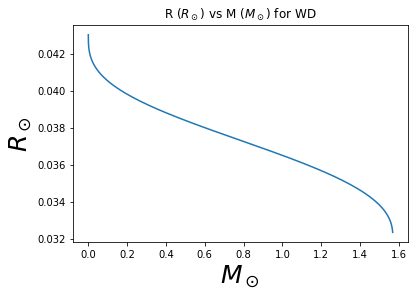

In [45]:
## Plot the solutions.
r_new = ((r * u.cm).to(u.R_sun)).value
M_new = ((y_WD_rk4[:,1] * u.g).to(u.M_sun)).value
plt.plot(M_new[:150], np.flip(r_new)[:150])
plt.xlabel(r"$M_\odot$", size = 25)
plt.ylabel(r"$R_\odot$", size = 25)
plt.title(r"R $(R_\odot)$ vs M $(M_\odot)$ for WD")

# Problem 5 - Neutron Star Mass vs Radius

In [21]:
## Define the pressure calculation found in Assignment 3, Eq. 5.
def pressure_calc_NS(dens):
    dens = dens * u.g / u.cm**3
    h = const.h
    amu = const.u
    m_n = const.m_n
    
    return ((1/20 * (3/np.pi)**(2/3) * h**2 / m_n**(8/3) * (dens)**(5/3)).to(u.Ba)).value
    
## Define the density calculation, found by solving for P in Assignment 3, Eq. 5.
def density_calc_NS(pres):
    h = const.h
    amu = const.u
    m_n = const.m_n
    
    pres = pres * u.Ba
    
    c1 = 20 / (3/np.pi)**(2/3)
    c2 = (m_n**(8/3))/h**2
    
    return (((pres * c1 * c2)**(3/5)).to(u.g / u.cm**3)).value

## Define Hydrostatic Equilibrium equations for a Neutron Star
def calc_NS(x, y):
    pi = np.pi
    G = const.G.cgs
    
    pressure = y[0] 
    M_enc = y[1]
        
    ## Update the density.
    density = density_calc_NS(pressure)
    
    ## Avoid hitting any numerical snags by requiring this.
    ## Without it, the solution will diverge to infinite Pressure. 
    ## It isn't necessarily a truly physical requirement but it seems
    ## to be required for the algorithm to survive.
    if M_enc == 0:
        dP_dr = 0
    
    ## Calculate dP_dr and dm_dr as found in Assignment 3, Eqs 1 and 2.
    else:
        dP_dr = -G.value * M_enc * density/x**2
        
    dm_dr = 4 * pi * x**2 * density
    
    ## Once we reach a negative pressure, we've made it to the edge. Pressure
    ## and enclosed mass are constant.
    if pressure < 0:
        dP_dr = 0
        dm_dr = 0
    
    return [dP_dr, dm_dr]
    
r = np.arange(0, 2e6, 5e2)

dens_0 = 1e17

y0 = [pressure_calc_NS(dens_0), 0]

## Solve the equations for a NS
## Notice that you will sometimes get RuntimeWarnings when you execute this. These errors
## come from the region where pressure < 0.
## I could build in a stop command once pressure < 0 to stop there. But
## I find it easier to simply remove those values in post-processing. 
y_NS_rk4 = ODE.rk4_method(calc_WD, y0, r, 5e2)

(6, 20)

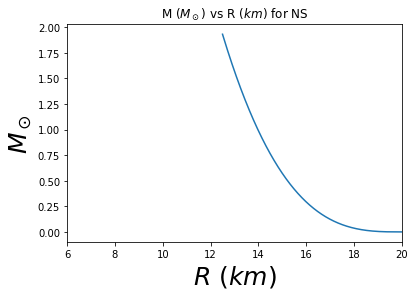

In [27]:
r_new = ((r * u.cm).to(u.km)).value
M_new = ((y_NS_rk4[:,1] * u.g).to(u.M_sun)).value
plt.plot(np.flip(r_new)[:1500], M_new[:1500])
plt.ylabel(r"$M_\odot$", size = 25)
plt.xlabel(r"$R \ (km)$", size = 25)
plt.title(r"M $(M_\odot)$ vs R $(km)$ for NS")
plt.xlim(6, 20)